### Accessing Data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing required libraries

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize, OneHotEncoder
import matplotlib.pyplot as plt

### Feature Engineering functions

In [ ]:
def apply_clahe(img):
    img = np.array(img)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

In [ ]:
def polynomial_transform(img):
    img = np.array(img) / 255.0
    poly = np.clip(img ** 2.2, 0, 1)
    return (poly * 255).astype(np.uint8)

In [ ]:
def preprocess_pipeline(img, use_clahe=False, use_poly=False):
    if use_clahe:
        img = apply_clahe(img)
    if use_poly:
        img = polynomial_transform(img)
    return img

### Data generator class

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, use_clahe=False, use_poly=False, shuffle=True):
        self.datagen = ImageDataGenerator(rescale=1./255)
        self.generator = self.datagen.flow_from_directory(
            directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=shuffle
        )
        self.use_clahe = use_clahe
        self.use_poly = use_poly

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        processed_images = np.array([
            preprocess_pipeline((img * 255).astype(np.uint8), self.use_clahe, self.use_poly)
            for img in images
        ])
        processed_images = processed_images / 255.0
        return processed_images, labels

### InceptionV3 model function

In [ ]:
def get_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Training Function

In [ ]:
def train_model(name, use_clahe=False, use_poly=False):
    data_dir = '/content/drive/MyDrive/ISIC_image_data'

    train_dir = os.path.join(data_dir, 'Train')
    val_dir = os.path.join(data_dir, 'Val')
    test_dir = os.path.join(data_dir, 'Test')

    train_gen = CustomDataGenerator(train_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly)
    val_gen = CustomDataGenerator(val_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly)
    test_gen = CustomDataGenerator(test_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly, shuffle=False)

    model = get_inception_model()

    checkpoint = ModelCheckpoint(f"best_model_{name}.h5", save_best_only=True, monitor='val_accuracy', mode='max')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[checkpoint, early_stop]
    )

    loss, acc = model.evaluate(test_gen)
    print(f"Test Accuracy for {name.upper()}: {acc:.4f}")

    y_true = []
    y_pred = []
    y_score = []

    for i in range(len(test_gen)):
        batch_imgs, batch_labels = test_gen[i]
        preds = model.predict(batch_imgs)
        y_true.extend(np.argmax(batch_labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        y_score.extend(preds)

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    target_names = ['Benign', 'Malignant']
    print(f"\nClassification Report for {name.upper()}:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_true_bin = enc.fit_transform(np.array(y_true).reshape(-1, 1))
    if y_true_bin.shape[1] == 1:
      print(f"Only one class present in test set for {name.upper()}. Skipping PR Curve.")
    else:
      plt.figure()
      for i, class_name in enumerate(target_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{class_name}')
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title(f'Precision-Recall Curve: {name.upper()}')
      plt.legend(loc='lower left')
      plt.grid(True)
      plt.show()

### Running Model for each variant

Running model for Clahe

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.7407 - loss: 0.4938

87/87 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7415 - loss: 0.4926 - val_accuracy: 0.8494 - val_loss: 0.3524
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 838ms/step - accuracy: 0.9742 - loss: 0.0883 - val_accuracy: 0.8434 - val_loss: 0.4813
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 826ms/step - accuracy: 0.9936 - loss: 0.0191 - val_accuracy: 0.8479 - val_loss: 0.5947
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - accuracy: 0.9983 - loss: 0.0094 - val_accuracy: 0.8494 - val_loss: 0.6721
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 1.0000 - loss: 0.0021

87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 846ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8720 - val_loss: 0.5923
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 826ms/step - accuracy: 1.0000 - loss: 4.3545e-04 - val_accuracy: 0.8705 - val_loss: 0.6102
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7969 - loss: 0.4026
Test Accuracy for CLAHE: 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Classification Report for CLAHE:
              precision    recall  f1-score   support

      Benign       0.70      0.88      0.78        40
   Malignant       0.83      0.62      0.71        40

    accuracy                           0.75        80
   macro avg       0.77      0.75      0.75        80
weighted avg       0.77      0.75      0.75        80



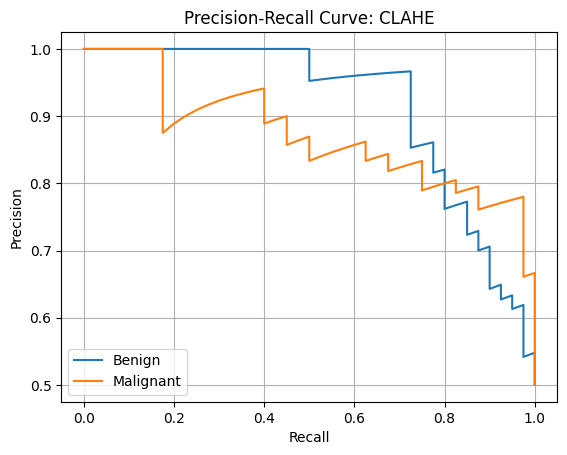

In [ ]:
train_model('clahe', use_clahe=True)

Running model for Polynomial

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.7537 - loss: 0.4602

87/87 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.7544 - loss: 0.4593 - val_accuracy: 0.7846 - val_loss: 0.5151
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9750 - loss: 0.0911

87/87 ━━━━━━━━━━━━━━━━━━━━ 76s 868ms/step - accuracy: 0.9749 - loss: 0.0911 - val_accuracy: 0.8343 - val_loss: 0.4489
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9897 - loss: 0.0255

87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 855ms/step - accuracy: 0.9897 - loss: 0.0255 - val_accuracy: 0.8479 - val_loss: 0.6797
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9960 - loss: 0.0144

87/87 ━━━━━━━━━━━━━━━━━━━━ 76s 860ms/step - accuracy: 0.9960 - loss: 0.0144 - val_accuracy: 0.8569 - val_loss: 0.6370
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 862ms/step - accuracy: 0.9907 - loss: 0.0214 - val_accuracy: 0.8012 - val_loss: 0.7404
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 838ms/step - accuracy: 0.9851 - loss: 0.0422 - val_accuracy: 0.8449 - val_loss: 0.7696
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9783 - loss: 0.0690

87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 836ms/step - accuracy: 0.9784 - loss: 0.0690 - val_accuracy: 0.8660 - val_loss: 0.7196
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8430 - loss: 0.3202
Test Accuracy for POLY: 0.8500
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Classification Report for POLY:
              precision    recall  f1-score   support

      Benign       0.85      0.85      0.85        40
   Malignant       0.85      0.85      0.85        40

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



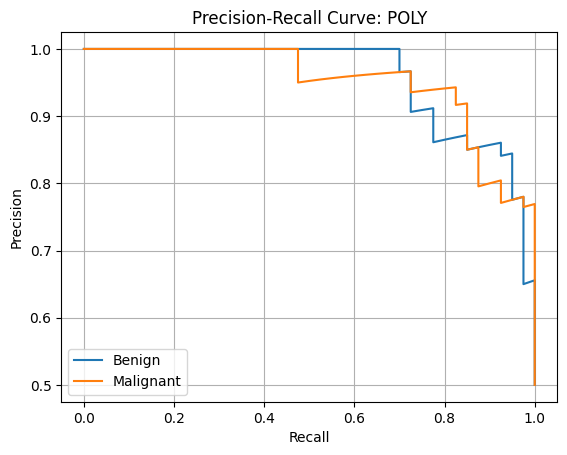

In [ ]:
train_model('poly', use_poly=True)

Running model for Polynomial + Clahe

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.7263 - loss: 0.5167

87/87 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7271 - loss: 0.5155 - val_accuracy: 0.8886 - val_loss: 0.2761
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 962ms/step - accuracy: 0.9655 - loss: 0.1135 - val_accuracy: 0.8780 - val_loss: 0.3393
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 84s 966ms/step - accuracy: 0.9977 - loss: 0.0177 - val_accuracy: 0.8735 - val_loss: 0.4275
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 924ms/step - accuracy: 0.9983 - loss: 0.0046 - val_accuracy: 0.8660 - val_loss: 0.4982
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 917ms/step - accuracy: 1.0000 - loss: 6.4892e-04 - val_accuracy: 0.8870 - val_loss: 0.4435
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 79s 909ms/step - accuracy: 1.0000 - loss: 2.4126e-04 - val_accuracy: 0.8825 - val_loss: 0.4729
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8242 - loss: 0.3458
Test Accuracy for CLAHE_POLY: 0.7500


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Classification Report for CLAHE_POLY:
              precision    recall  f1-score   support

      Benign       0.67      0.97      0.80        40
   Malignant       0.95      0.53      0.68        40

    accuracy                           0.75        80
   macro avg       0.81      0.75      0.74        80
weighted avg       0.81      0.75      0.74        80



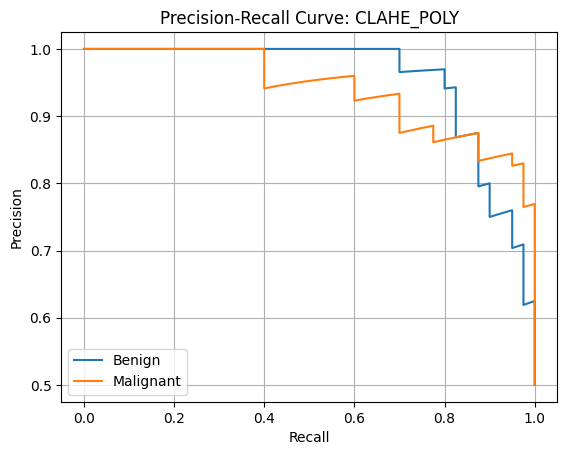

In [ ]:
train_model('clahe_poly', use_clahe=True, use_poly=True)